### Set MINI = TRUE to run with mini sample

In [1]:
"""
For TAs: Set TRUE to run with mini sample 
"""
MINI = False

In [2]:
if MINI:
    DATA_PATH = './data/crypto/BTC_1sec_MINI.csv'
    DATA_SIZE = 100_000
    EPOCHS = 5
else:
    DATA_PATH = './data/crypto/BTC_1sec.csv'
    DATA_SIZE = 400_000
    EPOCHS = 50
    
(DATA_PATH, DATA_SIZE, EPOCHS)

('./data/crypto/BTC_1sec.csv', 400000, 50)

Dataset can be directly downloaded from: https://www.kaggle.com/datasets/martinsn/high-frequency-crypto-limit-order-book-data

Or by running : kagglehub.dataset_download("martinsn/high-frequency-crypto-limit-order-book-data")

In [3]:
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from torchinfo import summary
from torch.utils.data import DataLoader

from models.deep_lob import DeepLOB
from models.trans_lob import TransLOB
from models.deep_trans_lob import DeepTransLOB
from utils.crypto_loader import load_crypto
from utils.training import train_validate, train, validate
from utils.plots import plot_training_history, plot_label_distributions
from utils.preprocessing import generate_labels, normalize_features

%load_ext autoreload
%autoreload 2

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
DATASET_TYPE = "crypto"
NORMALIZATION = "DecPre"

BATCH_SIZE = 128
WINDOW_SIZE = 100
LEVELS = 10
HORIZONS=[10, 20, 30, 50, 100]
TARGET_HORIZON = 20
LABEL_ALPHA = 1e-4

LEARNING_RATE = 1e-4
ADAM_B1 = 0.9
ADAM_B2 = 0.999
WEIGHT_DECAY= 1e-5

TEST_RATIO = 0.3

# EDA

In [6]:
raw_df = pd.read_csv(DATA_PATH, index_col=0)
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1030728 entries, 0 to 1030727
Columns: 155 entries, system_time to asks_market_notional_14
dtypes: float64(154), object(1)
memory usage: 1.2+ GB


In [7]:
DATA_PATH

'./data/crypto/BTC_1sec.csv'

In [8]:
meta_features = ['system_time', 'midpoint', 'spread', 'buys', 'sells']
distance_features = [f"{side}_distance_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
notional_features = [f"{side}_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]

raw_df['system_time'] = pd.to_datetime(raw_df['system_time'])
raw_df = raw_df[meta_features + distance_features + notional_features]
raw_df = generate_labels(raw_df, HORIZONS, alpha=LABEL_ALPHA)
raw_df = normalize_features(raw_df, NORMALIZATION)
raw_df

,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,bids_distance_4,...,asks_notional_5,asks_notional_6,asks_notional_7,asks_notional_8,asks_notional_9,y_10,y_20,y_30,y_50,y_100
0,2021-04-07 11:32:42.122161+00:00,56035.995,0.01,0.000000,0.000000,0.560360,0.560360,0.560332,0.560222,0.560199,...,0.000387,0.000064,0.000108,0.019618,0.005696,1,2,2,2,2
1,2021-04-07 11:32:43.122161+00:00,56035.995,0.01,0.000000,0.000000,0.560360,0.560360,0.560332,0.560222,0.560199,...,0.000387,0.000064,0.000108,0.019618,0.005696,1,2,2,2,2
2,2021-04-07 11:32:44.122161+00:00,56035.995,0.01,0.000000,0.000000,0.560360,0.560360,0.560332,0.560222,0.560199,...,0.000387,0.000064,0.000108,0.019618,0.005696,1,2,2,2,2
3,2021-04-07 11:32:45.122161+00:00,56035.995,0.01,0.000000,0.000000,0.560360,0.560360,0.560332,0.560222,0.560199,...,0.000387,0.000064,0.000108,0.019618,0.005696,1,2,2,2,2
4,2021-04-07 11:32:46.122161+00:00,56035.995,0.01,0.000000,0.000000,0.560360,0.560360,0.560332,0.560222,0.560199,...,0.000387,0.000064,0.000108,0.019618,0.005696,1,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030723,2021-04-19 09:54:18.386544+00:00,56863.725,0.01,0.000000,0.000000,0.568637,0.568637,0.568623,0.568623,0.568620,...,0.006916,0.000160,0.000236,0.000921,0.000921,1,1,1,1,1
1030724,2021-04-19 09:54:19.386544+00:00,56863.725,0.01,0.000000,0.000000,0.568637,0.568637,0.568623,0.568620,0.568618,...,0.004587,0.000921,0.000921,0.000921,0.034125,1,1,1,1,1
1030725,2021-04-19 09:54:20.386544+00:00,56863.725,0.01,1506.866100,0.000000,0.568637,0.568637,0.568623,0.568618,0.568579,...,0.004632,0.023753,0.004587,0.000921,0.000921,1,1,1,1,1
1030726,2021-04-19 09:54:21.386544+00:00,56863.725,0.01,0.000000,0.000000,0.568637,0.568637,0.568623,0.568618,0.568561,...,0.000921,0.000921,0.015529,0.004632,0.034121,1,1,1,1,1


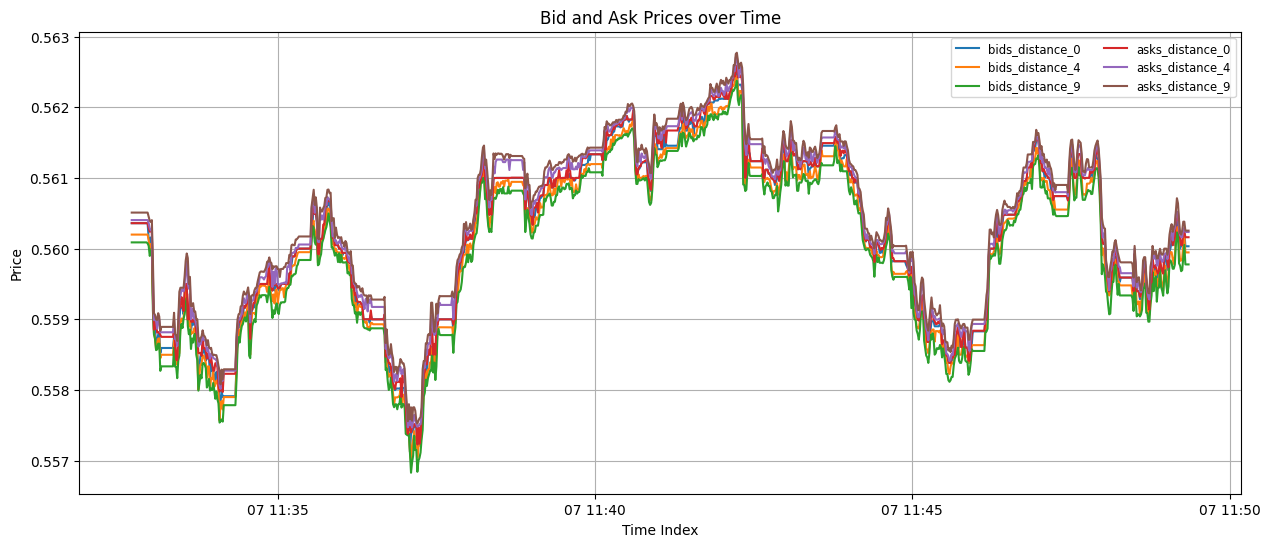

In [9]:
bid_price_cols = ['bids_distance_0','bids_distance_4','bids_distance_9']
ask_price_cols = ['asks_distance_0','asks_distance_4','asks_distance_9']

plot_range = 1000

plt.figure(figsize=(15, 6))

# Plot bids
for col in bid_price_cols:
    plt.plot(raw_df['system_time'][:plot_range], raw_df[col].values[:plot_range], label=col)#, color='blue', alpha=0.5)

# Plot asks
for col in ask_price_cols:
    plt.plot(raw_df['system_time'][:plot_range], raw_df[col].values[:plot_range], label=col)#, color='red', alpha=0.5)

plt.title('Bid and Ask Prices over Time')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid()
plt.show()

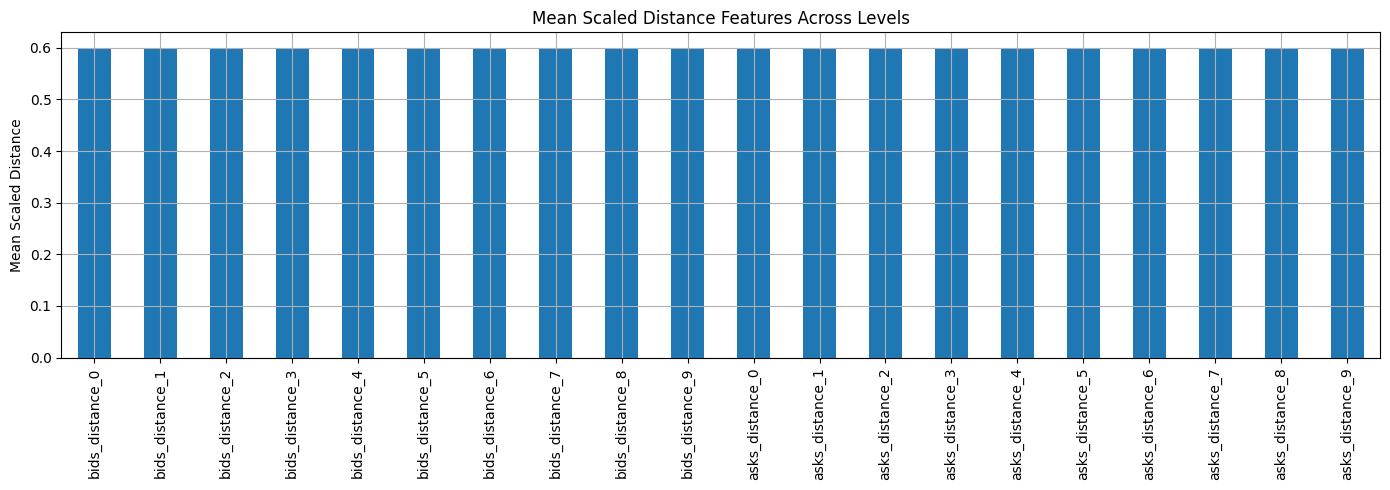

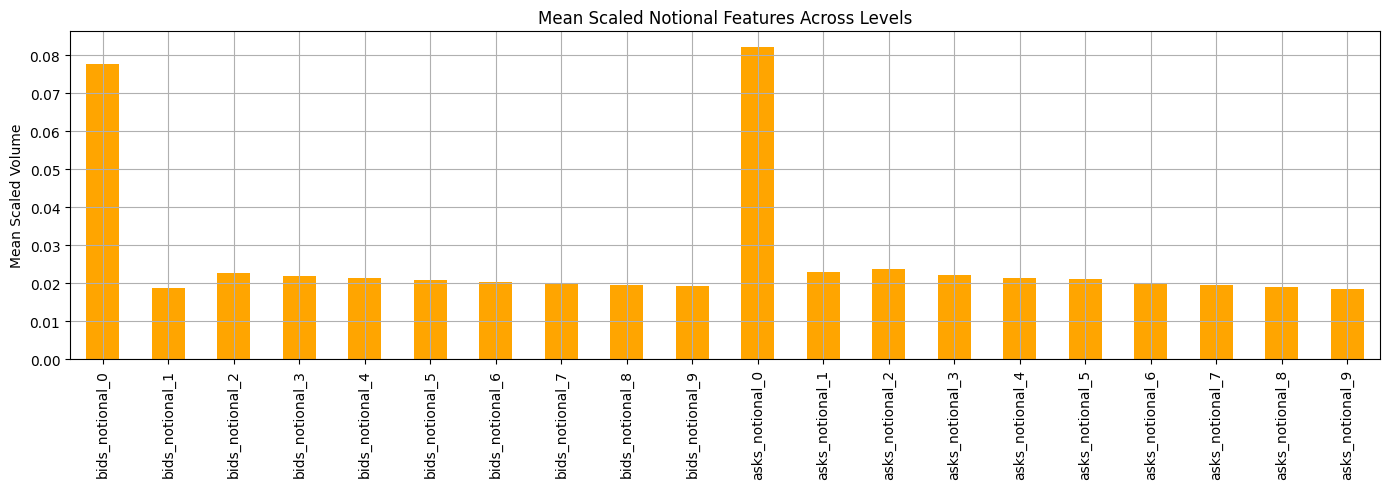

In [10]:
# Plot mean distance values across levels
plt.figure(figsize=(14, 5))
raw_df[distance_features].mean().plot(kind='bar', title='Mean Scaled Distance Features Across Levels')
plt.ylabel('Mean Scaled Distance')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot mean notional values across levels
plt.figure(figsize=(14, 5))
raw_df[notional_features].mean().plot(kind='bar', color='orange', title='Mean Scaled Notional Features Across Levels')
plt.ylabel('Mean Scaled Volume')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

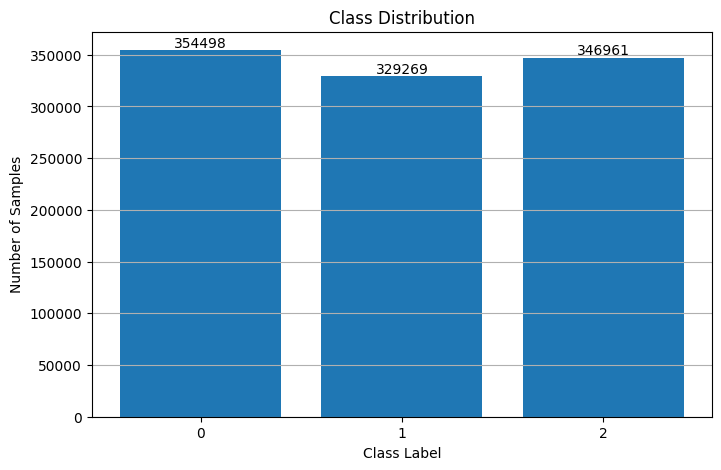

In [11]:
y_val_labels = np.array(raw_df['y_20'])
class_counts = np.bincount(y_val_labels)

class_labels = [0, 1, 2]

plt.figure(figsize=(8,5))
plt.bar(class_labels, class_counts)

plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(class_labels)
plt.grid(axis='y')

for i, count in enumerate(class_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

plt.show()

# DeepLOB

Train shape: (7000, 100, 40), (7000,)
Test shape: (3000, 100, 40), (3000,)
Training Data Size : 7000
Validation Data Size : 3000


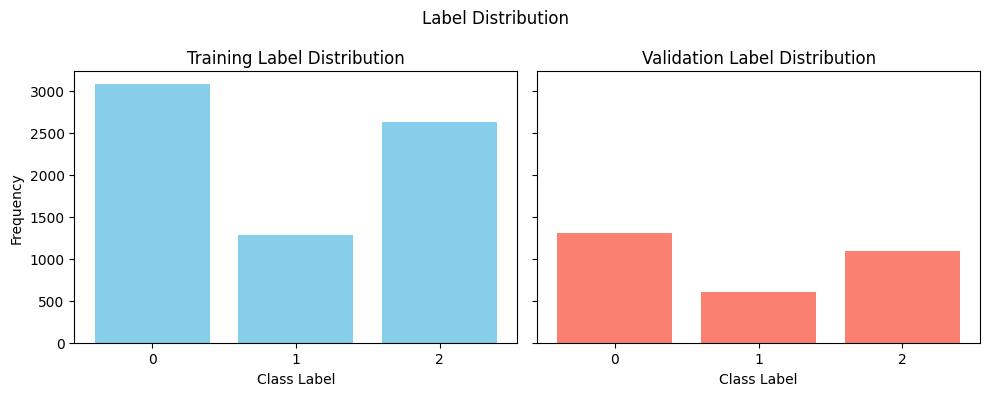

In [12]:
train_dataset, val_dataset = load_crypto(DATA_PATH, LEVELS, HORIZONS, TARGET_HORIZON, LABEL_ALPHA, 
                                     NORMALIZATION, TEST_RATIO, DATA_SIZE, WINDOW_SIZE, mode=True, log=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training Data Size : {train_dataset.__len__()}")
print(f"Validation Data Size : {val_dataset.__len__()}")

plot_label_distributions(train_dataset, val_dataset)

In [13]:
model_deepLOB = Deeplob().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deepLOB.parameters(), lr=LEARNING_RATE)

summary(model_deepLOB, (1, 1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
Deeplob                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 32, 94, 20]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 20]          96
│    └─LeakyReLU: 2-2                    [1, 32, 100, 20]          --
│    └─BatchNorm2d: 2-3                  [1, 32, 100, 20]          64
│    └─Conv2d: 2-4                       [1, 32, 97, 20]           4,128
│    └─LeakyReLU: 2-5                    [1, 32, 97, 20]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 97, 20]           64
│    └─Conv2d: 2-7                       [1, 32, 94, 20]           4,128
│    └─LeakyReLU: 2-8                    [1, 32, 94, 20]           --
│    └─BatchNorm2d: 2-9                  [1, 32, 94, 20]           64
├─Sequential: 1-2                        [1, 32, 88, 10]           --
│    └─Conv2d: 2-10                      [1, 32, 94, 10]           2,080
│    └

In [14]:
### If MINI, do not save model 

if not MINI: 
    history = train_validate(model_deepLOB, train_loader, val_loader, optimizer, criterion, EPOCHS, NORMALIZATION, DATASET_TYPE, device)
else:
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    for epoch in range(EPOCHS):
        train_loss, train_acc = train(model_deepLOB, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model_deepLOB, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{EPOCHS}: "
              f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.4f} | "
              f"Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f}")

Epoch 1/5: Train Loss 1.0823 | Train Acc 0.4394 | Val Loss 1.0788 | Val Acc 0.4207
Epoch 2/5: Train Loss 1.0608 | Train Acc 0.5297 | Val Loss 1.0578 | Val Acc 0.5077
Epoch 3/5: Train Loss 1.0098 | Train Acc 0.5967 | Val Loss 1.0033 | Val Acc 0.5567
Epoch 4/5: Train Loss 0.9139 | Train Acc 0.6781 | Val Loss 0.9295 | Val Acc 0.6357
Epoch 5/5: Train Loss 0.8371 | Train Acc 0.7349 | Val Loss 0.9325 | Val Acc 0.6157


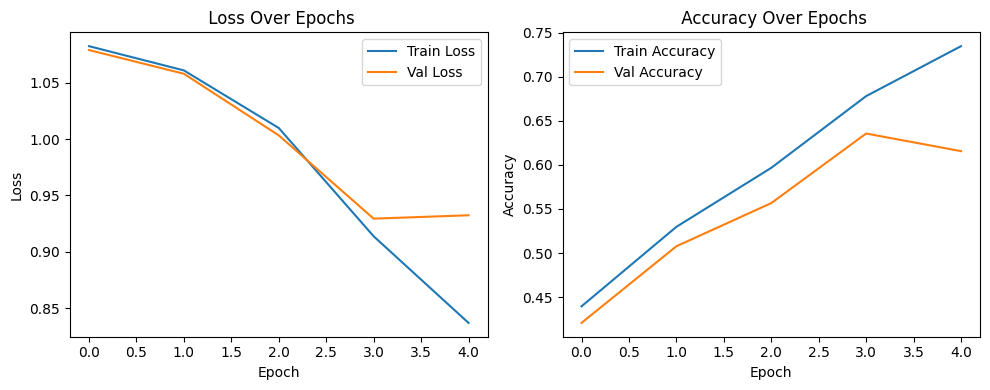

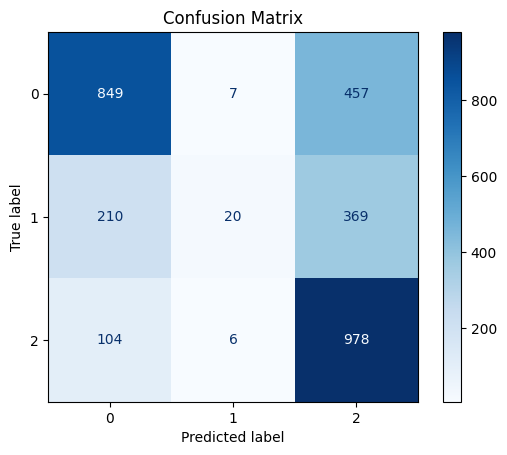

              precision    recall  f1-score   support

           0     0.7300    0.6466    0.6858      1313
           1     0.6061    0.0334    0.0633       599
           2     0.5421    0.8989    0.6763      1088

    accuracy                         0.6157      3000
   macro avg     0.6261    0.5263    0.4751      3000
weighted avg     0.6371    0.6157    0.5581      3000

Test Accuracy: 0.6157
Test Precision (macro): 0.6261
Test Recall (macro): 0.5263
Test F1 Score (macro): 0.4751


In [15]:
plot_training_history(history)
evaluate(model_deepLOB, val_loader, device)

# TransLOB

Train shape: (7000, 100, 40), (7000,)
Test shape: (3000, 100, 40), (3000,)
Training Data Size : 7000
Validation Data Size : 3000


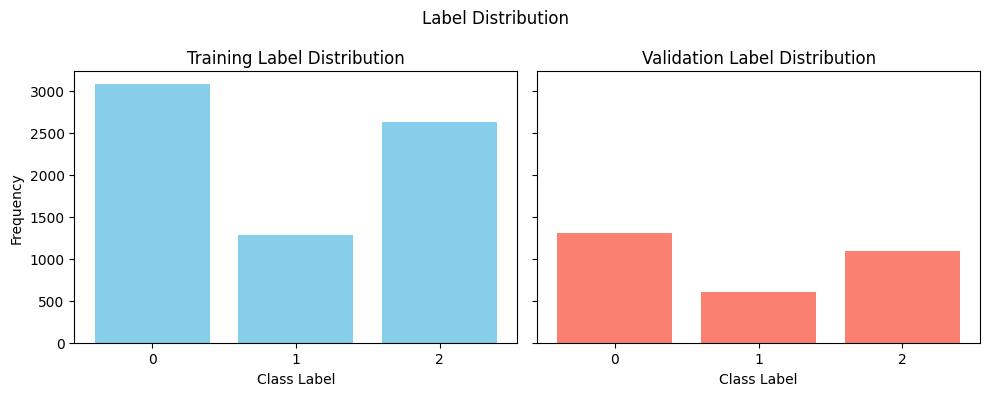

In [16]:
train_dataset, val_dataset = load_crypto(DATA_PATH, LEVELS, HORIZONS, TARGET_HORIZON, LABEL_ALPHA, 
                                     NORMALIZATION, TEST_RATIO, DATA_SIZE, WINDOW_SIZE, mode=False, log=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training Data Size : {train_dataset.__len__()}")
print(f"Validation Data Size : {val_dataset.__len__()}")

plot_label_distributions(train_dataset, val_dataset)

In [17]:
model_transLOB = TransLOB().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_transLOB.parameters(), lr=LEARNING_RATE)

summary(model_transLOB, (1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
TransLOB                                 [1, 3]                    --
├─LOBFeatureExtractor: 1-1               [1, 100, 14]              --
│    └─Conv1d: 2-1                       [1, 14, 100]              1,134
│    └─Conv1d: 2-2                       [1, 14, 100]              406
│    └─Conv1d: 2-3                       [1, 14, 100]              406
│    └─Conv1d: 2-4                       [1, 14, 100]              406
│    └─Conv1d: 2-5                       [1, 14, 100]              406
├─LayerNorm: 1-2                         [1, 100, 14]              28
├─LOBPositionalEncoding: 1-3             [1, 100, 15]              --
├─LOBTransformerBlock: 1-4               [1, 100, 15]              --
│    └─MultiheadAttention: 2-6           [1, 100, 15]              960
│    └─LayerNorm: 2-7                    [1, 100, 15]              30
│    └─Sequential: 2-8                   [1, 100, 15]              --
│    │ 

Epoch 1/5: Train Loss 1.0867 | Train Acc 0.3841 | Val Loss 1.0637 | Val Acc 0.4377
Epoch 2/5: Train Loss 1.0526 | Train Acc 0.4366 | Val Loss 1.0512 | Val Acc 0.4377
Epoch 3/5: Train Loss 1.0430 | Train Acc 0.4316 | Val Loss 1.0494 | Val Acc 0.4377
Epoch 4/5: Train Loss 1.0395 | Train Acc 0.4396 | Val Loss 1.0480 | Val Acc 0.4380
Epoch 5/5: Train Loss 1.0387 | Train Acc 0.4367 | Val Loss 1.0472 | Val Acc 0.4413


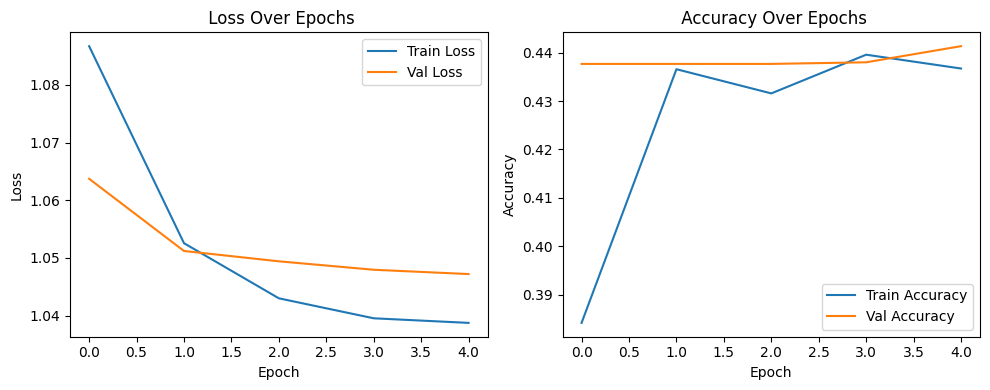

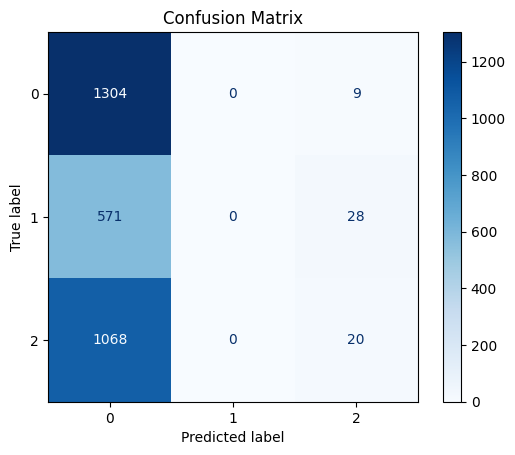

              precision    recall  f1-score   support

           0     0.4431    0.9931    0.6128      1313
           1     0.0000    0.0000    0.0000       599
           2     0.3509    0.0184    0.0349      1088

    accuracy                         0.4413      3000
   macro avg     0.2647    0.3372    0.2159      3000
weighted avg     0.3212    0.4413    0.2809      3000

Test Accuracy: 0.4413
Test Precision (macro): 0.2647
Test Recall (macro): 0.3372
Test F1 Score (macro): 0.2159


/home/sc3791/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sc3791/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sc3791/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sc3791/myenv/lib/py

In [18]:
### If MINI, do not save model 

if not MINI: 
    history = train_validate(model_transLOB, train_loader, val_loader, optimizer, criterion, EPOCHS, NORMALIZATION, DATASET_TYPE, device)
else:
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    for epoch in range(EPOCHS):
        train_loss, train_acc = train(model_transLOB, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model_transLOB, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{EPOCHS}: "
              f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.4f} | "
              f"Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f}")

plot_training_history(history)
evaluate(model_transLOB, val_loader, device)

# DeepTransLOB

Train shape: (280000, 100, 40), (280000,)
Test shape: (120000, 100, 40), (120000,)
Training Data Size : 280000
Validation Data Size : 120000


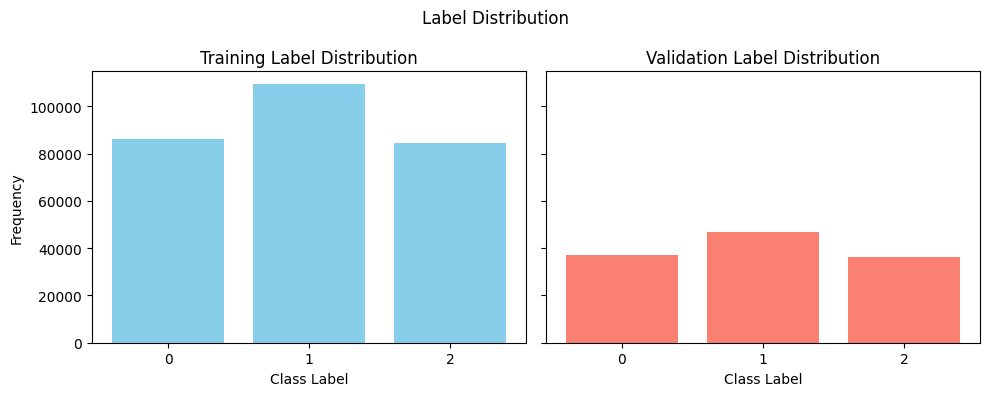

In [12]:
train_dataset, val_dataset = load_crypto(DATA_PATH, LEVELS, HORIZONS, TARGET_HORIZON, LABEL_ALPHA, 
                                     NORMALIZATION, TEST_RATIO, DATA_SIZE, WINDOW_SIZE, mode=False, log=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training Data Size : {train_dataset.__len__()}")
print(f"Validation Data Size : {val_dataset.__len__()}")

plot_label_distributions(train_dataset, val_dataset)

In [13]:
model_deepTransLOB = DeepTransLOB().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deepTransLOB.parameters(), lr=LEARNING_RATE)

summary(model_deepTransLOB, (1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
DeepTransLOB                             [1, 3]                    --
├─LOBFeatureExtractor2D: 1-1             [1, 100, 64]              --
│    └─Sequential: 2-1                   [1, 64, 100, 20]          --
│    │    └─CausalConv2d: 3-1            [1, 64, 100, 20]          192
│    │    └─LeakyReLU: 3-2               [1, 64, 100, 20]          --
│    │    └─BatchNorm2d: 3-3             [1, 64, 100, 20]          128
│    │    └─CausalConv2d: 3-4            [1, 64, 100, 20]          12,352
│    │    └─LeakyReLU: 3-5               [1, 64, 100, 20]          --
│    │    └─BatchNorm2d: 3-6             [1, 64, 100, 20]          128
│    │    └─CausalConv2d: 3-7            [1, 64, 100, 20]          12,352
│    │    └─LeakyReLU: 3-8               [1, 64, 100, 20]          --
│    │    └─BatchNorm2d: 3-9             [1, 64, 100, 20]          128
│    └─Sequential: 2-2                   [1, 64, 100, 10]          --
│  

In [ ]:
### If MINI, do not save model 

if not MINI: 
    history = train_validate(model_deepTransLOB, train_loader, val_loader, optimizer, criterion, EPOCHS, NORMALIZATION, DATASET_TYPE, device)
else:
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    for epoch in range(EPOCHS):
        train_loss, train_acc = train(model_deepTransLOB, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model_deepTransLOB, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{EPOCHS}: "
              f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.4f} | "
              f"Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f}")

Epoch 1/50, Train Loss: 1.0455, Train Acc: 0.4394, Validation Loss: 1.0308, Validation Acc: 0.4580
Epoch 2/50, Train Loss: 1.0195, Train Acc: 0.4666, Validation Loss: 1.0259, Validation Acc: 0.4604
Epoch 3/50, Train Loss: 0.9942, Train Acc: 0.4916, Validation Loss: 1.0357, Validation Acc: 0.4670
Epoch 4/50, Train Loss: 0.9556, Train Acc: 0.5225, Validation Loss: 0.9716, Validation Acc: 0.5093
Epoch 5/50, Train Loss: 0.9024, Train Acc: 0.5637, Validation Loss: 0.9861, Validation Acc: 0.5276
Epoch 6/50, Train Loss: 0.8406, Train Acc: 0.6082, Validation Loss: 0.9234, Validation Acc: 0.5637
Epoch 7/50, Train Loss: 0.7773, Train Acc: 0.6501, Validation Loss: 0.8721, Validation Acc: 0.6054
Epoch 8/50, Train Loss: 0.7202, Train Acc: 0.6853, Validation Loss: 0.8541, Validation Acc: 0.6339
Epoch 9/50, Train Loss: 0.6693, Train Acc: 0.7133, Validation Loss: 0.8890, Validation Acc: 0.6244
Epoch 10/50, Train Loss: 0.6277, Train Acc: 0.7366, Validation Loss: 0.8807, Validation Acc: 0.6318


In [ ]:
plot_training_history(history)
evaluate(model_deepTransLOB, val_loader, device)